In [3]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar, curve_fit
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
import pandas as pd

In [4]:
iris = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/\
0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv')

In [15]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [13]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [11]:
def p_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x)
    neighbors = np.empty((num_pts, k), dtype=np.int32)
    p_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return p + p.transpose() - (p.multiply(p.transpose()))

In [16]:
p = p_ij_sym(iris.to_numpy()[:,:4], 20, verbose=True)

Indexing


In [31]:
pp = p.tocoo()

In [53]:
head = pp.row
tail = pp.col

In [49]:
num_per_sample = np.asarray(500 * pp.data, np.int32)

In [55]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, num_per_sample),
        np.repeat(tail, num_per_sample),
    )

In [58]:
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask].astype(np.int32)
edges_from_exp = edges_from_exp[shuffle_mask].astype(np.int32)

In [71]:
dataset = torch.utils.data.TensorDataset(torch.tensor(edges_to_exp), torch.tensor(edges_from_exp))

In [72]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)

In [86]:
for data in dataloader:
    emb_to, emb_from = data
    break

In [81]:
foo = torch.stack((tox, fromx)).T

In [96]:
emb_neg_to = torch.repeat_interleave(emb_to, 5)
repeat_neg = torch.repeat_interleave(emb_from, 5)
emb_neg_from = repeat_neg[torch.randperm(repeat_neg.shape[0])]

In [108]:
(pp.toarray()[emb_neg_from, emb_neg_to] == 0.).sum() / len(emb_neg_to)

0.811

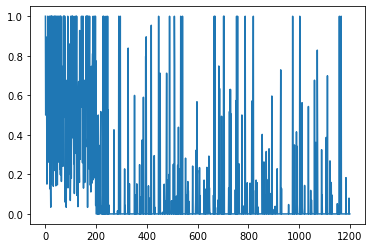

In [117]:
plt.plot(pp.toarray()[torch.cat((emb_from, emb_neg_from)), torch.cat((emb_to, emb_neg_to))])

In [114]:
torch.cat((emb_from, emb_neg_from))

tensor([ 58, 143,   7,  ..., 143,   2,  30], dtype=torch.int32)